## Deep learning model

In [20]:
# system tools
import os
import sys
sys.path.append(os.path.join(".."))

# pandas, numpy, gensim
import pandas as pd
import numpy as np
import gensim.downloader

# Machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics

# tools from tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Embedding, 
                                     Flatten, GlobalMaxPool1D, Conv1D)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import L2

# sklearn tools
from sklearn.preprocessing import LabelBinarizer

# additional packages
import matplotlib.pyplot as plt
from itertools import repeat
import itertools

__Functions for later__

In [21]:
def plot_history(H, epochs):
    """
    Utility function for plotting model history using matplotlib
    
    H: model history 
    epochs: number of epochs for which the model was trained
    """
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig("out/training_loss.png")
    plt.show()
    

def create_embedding_matrix(filepath, word_index, embedding_dim):
    """ 
    A helper function to read in saved GloVe embeddings and create an embedding matrix
    
    filepath: path to GloVe embedding
    word_index: indices from keras Tokenizer
    embedding_dim: dimensions of keras embedding layer
    """
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

__My data preparation__

In [22]:
# FUNCTIONS
# Balance data 
"""
Function to balance data.
dataframe = df to be balanced
colname = column with labels the data should be balanced according to
n = row per label
"""
def balance(dataframe, colname, n=500):

    # Use pandas select a random bunch of examples from each label
    out = (dataframe.groupby(colname, as_index=False)
            .apply(lambda x: x.sample(n=n))
            .reset_index(drop=True))
    
    return out

In [23]:
# Read the data as 'DATA' from the data folder
filename = os.path.join("data", "Game_of_Thrones_Script.csv")
DATA = pd.read_csv(filename, index_col=0)

In [24]:
# Get a list of uniques seasons (1 to 8)
seasons = DATA.Season.unique()

# Create empty list to save text chunks and corresponding labels
text = []
labels = []

In [25]:
# Loop over every season and chunk 20 lines together + save season label.
for i in seasons:
    
    # Get data from season
    season = DATA[DATA["Season"] == i]  
    
    # Get lines
    sentences = season["Sentence"]
    
    # Chunk lines together
    chunks = []
    for w in range(0, len(sentences), 5):
        chunks.append(' '.join(sentences[w:w+5]))
    
    # Save to lists outside the loop
    labels.extend(repeat(i, len(chunks)))
    text.append(chunks)

# From list of lists --> to list
text = list(itertools.chain(*text))

In [26]:
# I store the lists of data in a new df in order to balance the data.
df = pd.DataFrame()
df["season"] = labels
df["line_chunks"] = text

# Get the minimum amount of line chunks for a season - balance accordingly
min_count = df["season"].value_counts().min()

# Use predefined balance() function to balance amount of entrances across seasons
balanced = balance(df, "season", min_count)

# Extract information from the df
line_chunks = balanced["line_chunks"]
season = balanced["season"]

In [27]:
len(season) == len(line_chunks) # True

True

In [28]:
# Split the data in train and test.
X_train, X_test, y_train, y_test = train_test_split(line_chunks,     # sentences for the model
                                                    season,          # classification labels (seasons)
                                                    test_size=0.25,   # create an 70/30 split
                                                    random_state=42) # random state for reproducibility

In [29]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Binarize the labels
lb = LabelBinarizer() 
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

__Word embeddings__

In [30]:
# initialize tokenizer
# convert text into numbers (regardless of the length of the corpus we define this as 5000)
tokenizer = Tokenizer(num_words=10000)

# fit to training data - fit to the raw text data. vocabolary of 10000 words now fit onto our training data
tokenizer.fit_on_texts(X_train)

# tokenized training and test data
X_train_toks = tokenizer.texts_to_sequences(X_train)
X_test_toks = tokenizer.texts_to_sequences(X_test)

# overall vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# inspect
print(X_train[1])
print(X_train_toks[1])


Perhaps our paths will cross again? I hope they do. You treated him? Yes. Who told you to treat him?
[311, 56, 3684, 28, 1639, 154, 4, 369, 33, 22, 2, 1209, 36, 95, 53, 174, 2, 3, 1640, 36]


__Padding__ <br> To make the Tokenizer output workable, we need to pad the documents to be of equal length.

In [31]:
balanced['totalwords'] = balanced['line_chunks'].str.split().str.len()
maxlen = int(balanced[balanced['totalwords'] == balanced['totalwords'].max()]['totalwords'])

In [32]:

# pad training data to maxlen
X_train_pad = pad_sequences(X_train_toks, 
                            padding='post', # sequences can be padded "pre" or "post"
                            maxlen=maxlen) # maximum length
# pad testing data to maxlen
X_test_pad = pad_sequences(X_test_toks, 
                           padding='post', 
                           maxlen=maxlen)

In [33]:
# inspect
print(X_train[1])
print(X_train_toks[1])
print(X_train_pad[1])

Perhaps our paths will cross again? I hope they do. You treated him? Yes. Who told you to treat him?
[311, 56, 3684, 28, 1639, 154, 4, 369, 33, 22, 2, 1209, 36, 95, 53, 174, 2, 3, 1640, 36]
[ 311   56 3684   28 1639  154    4  369   33   22    2 1209   36   95
   53  174    2    3 1640   36    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    

## Install glove

In [34]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

## Using deep learning with pretrained ```GloVe``` embedding

In [35]:
embedding_dim = 50

embedding_matrix = create_embedding_matrix('glove.6B.50d.txt',
                                           tokenizer.word_index, 
                                           embedding_dim)

# create embedding matrix with the words that appear in the data.
# We use the embedding matrix as weights (pretrained word embeddings rather than just learning weights from our own data)

create regularizer

In [36]:
l2 = L2(0.0001)

In [37]:
# New model
model = Sequential()

# Embedding -> CONV+ReLU -> MaxPool -> FC+ReLU -> Out
model.add(Embedding(vocab_size,                  # vocab size from Tokenizer()
                    embedding_dim,               # embedding input layer size
                    weights=[embedding_matrix],  # pretrained embeddings
                    input_length=maxlen,         # maxlen of padded doc
                    trainable=True))             # trainable embeddings

model.add(Conv1D(128, 5, # added at teh convolutional layer
                activation='relu',
                kernel_regularizer=l2))          # L2 regularization 
model.add(GlobalMaxPool1D())
model.add(Dense(32, activation='relu', kernel_regularizer=l2))
model.add(Dense(8, activation='softmax'))

# compile
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# print summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 288, 50)           322650    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 284, 128)          32128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
Total params: 359,170
Trainable params: 359,170
Non-trainable params: 0
_________________________________________________________________


[0.03155830129981041, 1.0]

Training Accuracy: 1.0000
Testing Accuracy:  0.2364


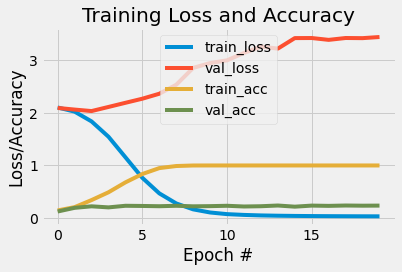

In [38]:
history = model.fit(X_train_pad, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

# evaluate 
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# plot
plot_history(history, epochs = 20)